## Importing data from Master Creep Data

In [2]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from math import sqrt,pi,sinh

### Defining a class for time and strain data, constants

In [3]:
A = 5.966816326530612e-10 # /s
C = 0.00010228

In [4]:
# New 

A = 6.1307620301057776e-12
C = 0.010421856726519777

In [53]:
class Cdata:
    
    '''
    .curve() - plots creep curve
    .plotss() - plots steady state creep
    .plotsst() - plots secondary and tertiary creep
    .plotpsize() - plots particle size and spacing
    .plotcmodelonly() - plots creep model outout
    .plotcreep() - plots secondary and tertiary creep data and creep model
    .plotcreepss() - plots secondary creep data and creep model
    '''

    def __init__(self, df, alloy, tem, stress, ssstart, ssend,A,C,rho,mech='climb'):
        #         self.tc = df.iloc[:,1:3]
        self.t = df.iloc[:, 1:2]
        self.c = df.iloc[:, 2:3] * 0.01
        self.tem = tem
        self.stress = stress
        self.mech = mech
        if alloy == 1:
            self.name = 'GP only'
            self.f = 0.15
        elif alloy == 2:
            self.name = 'GPnE'
            self.f = 0.07
        else:
            self.name = 'Eta only'
            self.f = 0.01
        self.ssstart = ssstart
        self.ssend = ssend
        self.calcss()
        self.par_size()
        self.A = A
        self.C = C
        self.rho = abs(rho)
        self.cmodel()
        self.calcerror()
          
    def calcerror(self):
        self.dataslope = (self.dfss.strain.iloc[-1] - self.dfss.strain.iloc[0])/(self.dfss.time.iloc[-1] - self.dfss.time.iloc[0])
        self.error = (self.dataslope - self.modelslope) / self.dataslope # Lower is better
        
    def printerror(self): 
        '''Calculates and prints error'''
        self.calcerror()
        print(f'{self.name} {self.tem}C {self.stress}MPa condition with {self.mech} mechanism - error: {self.error}')

    def geterror(self):
        return self.error

    def calcss(self):
        ''' 
        self.dfss - steady state
        self.dft - tertiary
        '''
        # Secodary
        self.dfss = pd.concat([self.t, self.c], axis=1)
        self.dfss.columns = ['time', 'strain']
        self.dfss = self.dfss[(self.dfss.time > self.ssstart)
                              & (self.dfss.time < self.ssend)]
#         print(f'Start {self.dfss.head(1)} end {self.dfss.tail(1)}')
        initime = self.dfss.time.iloc[0]
        inistr = self.dfss.strain.iloc[0]
        self.dfss.time = self.dfss.time - initime
        self.dfss.strain = self.dfss.strain - inistr

        # Tertiary
        self.dft = pd.concat([self.t, self.c], axis=1)
        self.dft.columns = ['time', 'strain']
        self.dft = self.dft[(self.dft.time > self.ssend)]

        self.dft.time = self.dft.time - initime
        self.dft.strain = self.dft.strain - inistr

    def par_size(self):
        
        # These parameters are fitted for temp = 750, 800, 850 only NEED 700!
        R0 = ((5.746e-06)*self.tem**2) + ((-0.008741)*self.tem) + (3.357)
        K = ((9.954e-12)*self.tem**2) + ((-1.316e-08)*self.tem) + (4.36e-06)

#         # THIS NEEDS TO BE UPDATED TO MATCH TEMPERATURES!!!!!
#         r800 = 0.04235
#         k800 = 2e-7

        self.psize = [1e-6*((R0**3) + (K*t)) ** (1/3) for t in range(10000)] #m # 0h to 10,000h
        self.pspace = [1.6 * i * (sqrt(pi/(4*self.f)) - 1) for i in self.psize] #m # 0h to 10,000h

    def cmodel(self):
        
        T = self.tem + 273.15 # K

        k = 1.38064852e-23 # J/K % m2 kg / s2 K
        # Elastic modulus of N263 wrt T(K)
        # Fitted between 600C and 900C
        E = (-6.6667e-04 * T**3) + (1.8963 * T**2) + (-1.8751e+03 * T) + 8.2027e+05 #MPa
        G = E / 2*(1+0.3) # MPa
        G_inPascal = G*1e6 # Pa
        M=3.07
        burgers = 2.540e-10 # m
        APB = 0.15 # <---------- check check, check check

        time = list(range(int(self.dft.time.iloc[-1]))) # 0 to end of creep test
        timesec = [i * 3600 for i in time]
        dt = timesec[2]-timesec[1] #3600

        ## Handling particle spacing
        # We need to consider pspacing from start of stead state creep + time in furnace
        # 24h + 150h

#         psize_rel = self.psize[(self.ssstart):time[-1]]
#         pspace_rel = self.pspace[(self.ssstart):time[-1]]
        psize_rel = self.psize[(self.ssstart):(self.ssend)]
        pspace_rel = self.pspace[(self.ssstart):(self.ssend)]
                
        stress_0 = 0.25 * G * burgers * M * sqrt(self.rho)
        
        self.stress_climb = [self.stress * 2*self.f/(1+(2*self.f)) for i in psize_rel]
        self.stress_shear = [1e-6 * (APB/(2*burgers)) * (sqrt(12*APB*self.f*r/(pi*G_inPascal*(burgers**2)))-self.f) for r in psize_rel]
                
        if self.mech == 'climb':
            self.stress_total = [max(0,(self.stress - stress_0 - climb)) for climb in self.stress_climb]
        else: # shear
            self.stress_total = [max(0,(self.stress - stress_0 - shear)) for shear in self.stress_shear]
        
        if 0 in self.stress_total:
            print(f'{self.name} {self.tem}C {self.stress}MPa - Zero effective stress detected at some point')
            
        self.strain = 0

        sinh_term =  [self.C * str_total * (burgers**2) * i * 1e6 / (M * k * T) for i,str_total in zip(pspace_rel,self.stress_total)]
        strain_inst = [dt * (1.6/M) * self.rho*(1-self.f)*self.f*(sqrt(pi/(4*self.f))-1)* self.A * sinh(i)
                           for i in sinh_term]
        #strain += np.asarray(strain_inst)
        self.strain = np.cumsum(strain_inst)
        
#         self.modelslope = (self.strain[self.ssend-self.ssstart] - self.strain[0])/(time[self.ssend-self.ssstart] - time[0])
        self.modelslope = (self.strain[-1] - self.strain[0])/(time[self.ssend-self.ssstart] - time[0])

    def export_params(self,dct,expected_mech):
        placeholder = self.mech
        self.mech = 'climb'
        self.cmodel()
        self.calcerror()
        self.climberror = self.error
        
        self.mech = 'shear'
        self.cmodel()
        self.calcerror()
        self.shearerror = self.error
        
        self.mech = placeholder
        self.cmodel()
        self.calcerror()
        
        key = f'{self.name} {self.tem}C {self.stress}MPa'
        dct[key] = [expected_mech,self.rho,self.climberror,self.shearerror,self.modelslope,self.dataslope,self.ssstart,self.ssend]
        
    def __repr__(self):
        return (f'{self.t.iloc[[-1]]} hours {self.c.iloc[[-1]]} percent')

    def curve(self): # Plots creep curve data

        plt.figure(figsize=(9, 9))
        plt.plot(self.t, self.c, linewidth=2.0, label="Creep data")
        plt.title(f'{self.name} {self.tem}C {self.stress}MPa', fontsize=14)
        plt.xlabel('Time (hrs)', fontsize=14)
        plt.ylabel('Strain', fontsize=14)
        plt.legend(loc="upper left")
        plt.grid(alpha = 0.4, linestyle='-')
        plt.show()

    def plotss(self): # Plots steady state creep data

        plt.figure(figsize=(9, 9))
        plt.plot(self.dfss.time, self.dfss.strain, linewidth=2.0, label="Creep data")
        plt.title(
            f'{self.name} {self.tem}C {self.stress}MPa steady state creep from {self.ssstart} to {self.ssend} hours', fontsize=14)
        plt.xlabel('Time (hrs)', fontsize=14)
        plt.ylabel('Strain', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()

    def plotsst(self): # Plots steady state and tertiary creep data

        plt.figure(figsize=(9, 9))
        plt.plot(self.dfss.time, self.dfss.strain, linewidth=2.0, label="Steady State Creep data")
        plt.plot(self.dft.time, self.dft.strain, linewidth=2.0, label="Tertiary Creep data")
        plt.title(
            f'{self.name} {self.tem}C {self.stress}MPa tertiary creep after {self.ssend} hours', fontsize=14)
        plt.xlabel('Time (hrs)', fontsize=14)
        plt.ylabel('Strain', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()

    def plotpsize(self): # Plots particle size and volume fraction
        plt.figure(figsize=(9, 9))
        plt.plot(self.psize)
        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Particle size', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Size (um)', fontsize=14)
        plt.show()

        plt.figure(figsize=(9, 9))
        plt.plot(self.pspace)
        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Particle space', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Size (um)', fontsize=14)
        plt.show()
        
    def plotcmodelonly(self): # Plots only the creep model output
        plt.figure(figsize=(9, 9))
        plt.plot(self.strain, label="Creep model")

        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - {self.mech}', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Creep', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()
        
    def plotcreep(self): # Plots steady state, tertiary creep with model
        plt.figure(figsize=(9, 9))
        plt.plot(self.strain, label="Creep model")
        plt.plot(self.dfss.time,self.dfss.strain,linewidth=2.0, label="Steady State Creep data")
        plt.plot(self.dft.time,self.dft.strain,linewidth=2.0, label="Tertiary Creep data")
        
        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - {self.mech}', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Creep', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()
        
    def plotcreepss(self): # Plots steady state creep with model
        plt.figure(figsize=(9, 9))
        plt.plot(self.strain, label="Creep model") #self.strain[0:(self.ssend-self.ssstart)]
        plt.plot(self.dfss.time,self.dfss.strain,linewidth=2.0, label="Creep data")
        
        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - {self.mech}', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Creep', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()
        
    def plotcomb(self): # Plots custom combination of graphs - edit this if needed
#         self.curve()
#         self.plotsst()
        self.plotcreep()
        self.plotcreepss()

    def plotstress(self):
        plt.figure(figsize=(9, 9))
        plt.plot(self.stress_climb, label="Climb stress")
        plt.plot(self.stress_shear, label="Shear stress")
        plt.plot(self.stress_total, label="Total stress")

        plt.title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - back stress', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Stress', fontsize=14)
        plt.legend(loc="upper left")
        plt.show()
        
    def changemech(self):
        if self.mech == 'climb':
            self.mech = 'shear'
        else:
            self.mech = 'climb'
        self.cmodel()
        self.plotcreepss()
    
    def plotboth(self):
        placeholder = self.mech
        self.mech = 'climb'
        self.cmodel()
        
        self.printerror()
        
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,9))
        ax1.plot(self.strain, label="Creep model")
        ax1.plot(self.dfss.time,self.dfss.strain,linewidth=2.0, label="Creep data")
        
        ax1.set_title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - {self.mech}', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Creep', fontsize=14)
        ax1.legend(loc="upper left")
        
        self.mech = 'shear'
        self.cmodel()
        self.printerror()
        ax2.plot(self.strain, label="Creep model")
        ax2.plot(self.dfss.time,self.dfss.strain,linewidth=2.0, label="Creep data")
        
        ax2.set_title(f'{self.name} {self.tem}C {self.stress}MPa Creep Model - {self.mech}', fontsize=14)
        plt.xlabel('Time (hr)', fontsize=14)
        plt.ylabel('Creep', fontsize=14)
        ax2.legend(loc="upper left")
        self.mech = placeholder
        
    def subplots(self,plotting):
        
# #         Model and steady state
#         plt.plot(self.strain) #self.strain[0:(self.ssend-self.ssstart)]
#         plt.plot(self.dfss.time,self.dfss.strain,linewidth=2.0)
        
        # Just steady state, with self.dataslope in legend
        if plotting:
            plt.plot(self.dfss.time,self.dfss.strain,linewidth=2.0,label=f'{self.name} {self.dataslope}')
        return self.dataslope
        
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.suptitle('Horizontally stacked subplots')
#     ax1.plot(x, y)
#     ax2.plot(x, -y)

### TESTING

In [ ]:
gpe800250 = Cdata(sheet5.iloc[27:, 45:47].dropna().reset_index(),2,800,250,4,42,A,C,500000)


In [52]:
# gp800100.plotboth()
gp800100.modelslope

0.0

#### End of testing

### Import data

In [40]:
# sheet1 = pd.read_excel(open('Master creep data.xlsx', 'rb'), sheet_name='1. N263')
# sheet1.to_pickle('sheet1.pkl')
sheet1 = pd.read_pickle('sheet1.pkl')

In [54]:
gp700280 = Cdata(sheet1.iloc[15:, 3:5].dropna().reset_index(),1,700,280,350,750,A,C,5773,mech='shear')
gp700320 = Cdata(sheet1.iloc[15:, 9:11].dropna().reset_index(),1,700,320,50,160,A,C,14282,mech='shear') #50 170 100 140
gp700350 = Cdata(sheet1.iloc[15:, 6:8].dropna().reset_index(),1,700,350,50,300,A,C,10028,mech='shear')
gp700400 = Cdata(sheet1.iloc[15:, 21:23].dropna().reset_index(),1,700,400,10,70,A,C,95125,mech='shear')

gp750150 = Cdata(sheet1.iloc[15:, 18:20].dropna().reset_index(),1,750,150,500,2500,A,C,24211)
gp750180 = Cdata(sheet1.iloc[15:, 0:2].dropna().reset_index(),1,750,180,500,1500,A,C,30000)
gp750198 = Cdata(sheet1.iloc[15:, 12:14].dropna().reset_index(),1,750,198,130,300,A,C,53548)
gp750200 = Cdata(sheet1.iloc[15:, 15:17].dropna().reset_index(),1,750,200,550,1000,A,C,82000) # 53548 #tried 82000,74000

In [42]:
# sheet5 = pd.read_excel(open('Master creep data.xlsx', 'rb'), sheet_name='5. EPRI MTU')
# sheet5.to_pickle('sheet5.pkl')
sheet5 = pd.read_pickle('sheet5.pkl')

In [55]:

gp750300 = Cdata(sheet5.iloc[27:, 0:2].dropna().reset_index(),1,750,300,10,40,A,C,66760)
gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(),1,800,100,150,1400,A,C,6000)
gp800125 = Cdata(sheet5.iloc[27:, 6:8].dropna().reset_index(),1,800,125,150,800,A,C,6100)
gp800145 = Cdata(sheet5.iloc[27:, 9:11].dropna().reset_index(),1,800,145,2,4,A,C,6200) # Negative creep
gp800250 = Cdata(sheet5.iloc[27:, 42:44].dropna().reset_index(),1,800,250,4,15,A,C,500000)

gpe700325 = Cdata(sheet5.iloc[27:, 15:17].dropna().reset_index(),2,700,325,50,400,A,C,14282)
gpe700400 = Cdata(sheet5.iloc[27:, 18:20].dropna().reset_index(),2,700,400,20,140,A,C,95125)
gpe750200 = Cdata(sheet5.iloc[27:, 24:26].dropna().reset_index(),2,750,200,35,300,A,C,82000) #53548)
gpe750300 = Cdata(sheet5.iloc[27:, 27:29].dropna().reset_index(),2,750,300,20,100,A,C,66760)
gpe800100 = Cdata(sheet5.iloc[27:, 30:32].dropna().reset_index(),2,800,100,100,1100,A,C,6000)
gpe800125 = Cdata(sheet5.iloc[27:, 33:35].dropna().reset_index(),2,800,125,100,400,A,C,6100)
gpe800145 = Cdata(sheet5.iloc[27:, 36:38].dropna().reset_index(),2,800,145,30,200,A,C,6200) # Change this
# gpe800250old = Cdata(sheet5.iloc[27:, 39:41].dropna().reset_index(),2,800,250,1,5,A,C,500000)
gpe800250 = Cdata(sheet5.iloc[27:, 45:47].dropna().reset_index(),2,800,250,4,42,A,C,500000)



In [44]:
# sheet2 = pd.read_excel(open('Master creep data.xlsx', 'rb'), sheet_name='2. WMTR')
# sheet2.to_pickle('sheet2.pkl')
sheet2 = pd.read_pickle('sheet2.pkl')
# sheet3 = pd.read_excel(open('Master creep data.xlsx', 'rb'), sheet_name='3. SE')
# sheet3.to_pickle('sheet3.pkl')
sheet3 = pd.read_pickle('sheet3.pkl')
# sheet4 = pd.read_excel(open('Master creep data.xlsx', 'rb'), sheet_name='4. EPRI')
# sheet4.to_pickle('sheet4.pkl')
sheet4 = pd.read_pickle('sheet4.pkl')

In [56]:
e700325_1 = Cdata(sheet4.iloc[24:, 0:2].dropna().reset_index(),3,700,325,5,75,A,C,10000)
e700325_2 = Cdata(sheet4.iloc[24:, 12:14].dropna().reset_index(),3,700,325,50,150,A,C,10000)
e700380 = Cdata(sheet4.iloc[24:, 36:38].dropna().reset_index(),3,700,380,10,40,A,C,10000)
e700400_1 = Cdata(sheet2.iloc[20:, 0:2].dropna().reset_index(),3,700,400,10,30,A,C,10000)
e700400_2 = Cdata(sheet2.iloc[20:, 12:14].dropna().reset_index(),3,700,400,10,30,A,C,10000)

e750125 = Cdata(sheet4.iloc[24:, 27:29].dropna().reset_index(),3,750,125,100,3800,A,C,10000)
e750160 = Cdata(sheet3.iloc[11:, 0:2].dropna().reset_index(),3,750,160,10,600,A,C,10000)
e750220 = Cdata(sheet4.iloc[24:, 3:5].dropna().reset_index(),3,750,220,5,100,A,C,10000)
e750275 = Cdata(sheet4.iloc[24:, 24:26].dropna().reset_index(),3,750,275,5,30,A,C,10000)
e750300_1 = Cdata(sheet2.iloc[20:, 3:5].dropna().reset_index(),3,750,300,5,20,A,C,10000)
e750300_2 = Cdata(sheet2.iloc[20:, 15:17].dropna().reset_index(),3,750,300,5,20,A,C,10000)

e800040 = Cdata(sheet4.iloc[24:, 15:17].dropna().reset_index(),3,800,40,500,4000,A,C,10000)
e800070 = Cdata(sheet3.iloc[11:, 3:5].dropna().reset_index(),3,800,70,250,1400,A,C,10000)
e800100_1 = Cdata(sheet3.iloc[11:, 6:8].dropna().reset_index(),3,800,100,200,600,A,C,10000)
e800100_2 = Cdata(sheet4.iloc[24:, 39:41].dropna().reset_index(),3,800,100,250,800,A,C,10000)
e800145_1 = Cdata(sheet4.iloc[24:, 6:8].dropna().reset_index(),3,800,145,100,200,A,C,10000)
e800145_2 = Cdata(sheet4.iloc[24:, 18:20].dropna().reset_index(),3,800,145,5,75,A,C,10000) # Incomplete
e800145_3 = Cdata(sheet4.iloc[24:, 21:23].dropna().reset_index(),3,800,145,5,75,A,C,10000)
e800206 = Cdata(sheet4.iloc[24:, 30:32].dropna().reset_index(),3,800,206,10,30,A,C,10000)
e800250_1 = Cdata(sheet2.iloc[20:, 6:8].dropna().reset_index(),3,800,250,4,12,A,C,10000)
e800250_2 = Cdata(sheet2.iloc[20:, 18:20].dropna().reset_index(),3,800,250,4,10,A,C,10000)

# e850050 = Cdata(sheet3.iloc[11:, 9:11].dropna().reset_index(),3,850,50,5,75,A,C,10000)
# e850060 = Cdata(sheet3.iloc[11:, 12:14].dropna().reset_index(),3,850,60,5,75,A,C,10000)
# e850080 = Cdata(sheet4.iloc[24:, 9:11].dropna().reset_index(),3,850,80,5,75,A,C,10000)
# e850125 = Cdata(sheet4.iloc[24:, 33:35].dropna().reset_index(),3,850,125,5,75,A,C,10000)
# e850150_1 = Cdata(sheet2.iloc[20:, 9:11].dropna().reset_index(),3,850,150,5,75,A,C,10000)
# e850150_2 = Cdata(sheet2.iloc[20:, 21:23].dropna().reset_index(),3,850,150,5,75,A,C,10000)

### Plots

#### 700C 280MPa

In [10]:
gp700280 = Cdata(sheet1.iloc[15:, 3:5].dropna().reset_index(),1,700,280,350,750,A,C,5773)

GP only 700C 280MPa condition with climb mechanism - error: -1.6691339332657937
GP only 700C 280MPa condition with shear mechanism - error: -0.0875704681302568


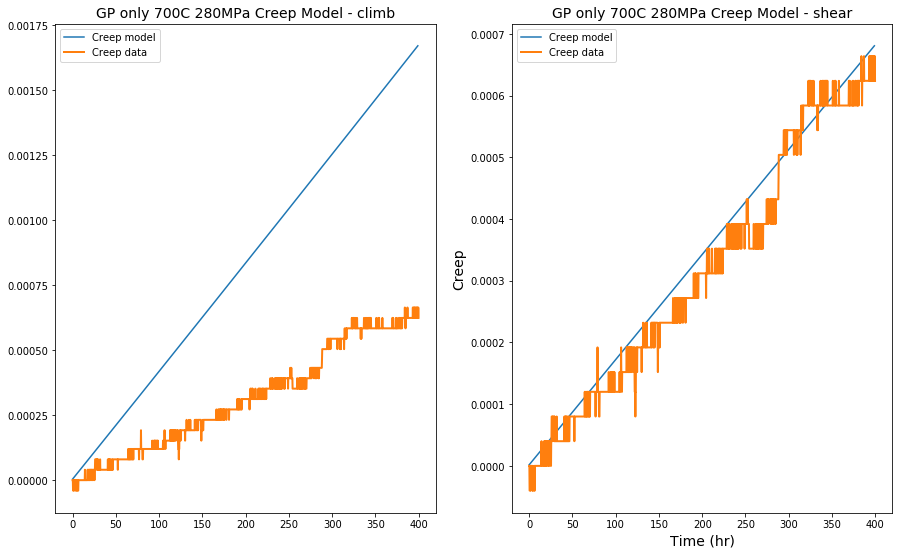

In [11]:
gp700280.plotboth()

#### 700C 325MPa

In [12]:
gp700320 = Cdata(sheet1.iloc[15:, 9:11].dropna().reset_index(),1,700,320,50,160,A,C,14282) #50 170 100 140
gpe700325 = Cdata(sheet5.iloc[27:, 15:17].dropna().reset_index(),2,700,325,50,400,A,C,14282)

GP only 700C 320MPa condition with climb mechanism - error: -0.9167428073205471
GP only 700C 320MPa condition with shear mechanism - error: -0.015876893605986955


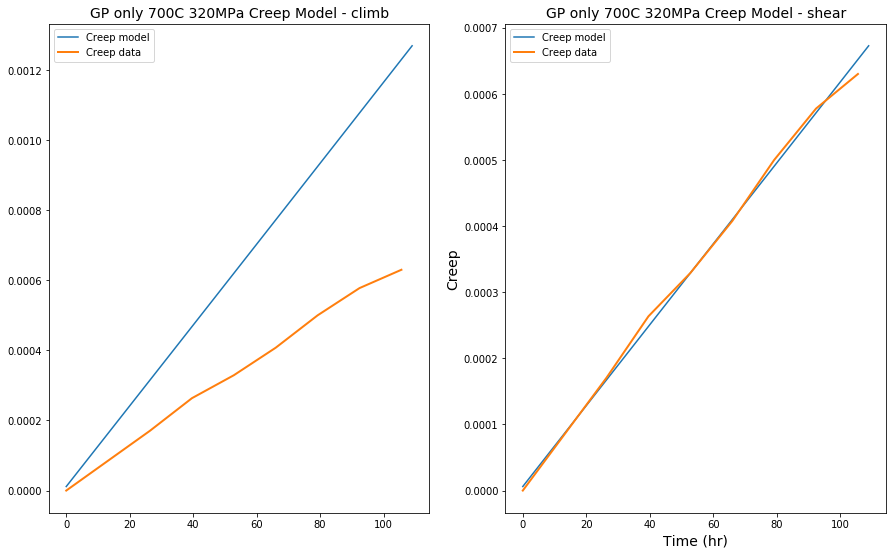

In [13]:
gp700320.plotboth()

GPnE 700C 325MPa condition with climb mechanism - error: 0.11450279899692084
GPnE 700C 325MPa condition with shear mechanism - error: 0.4240629649865921


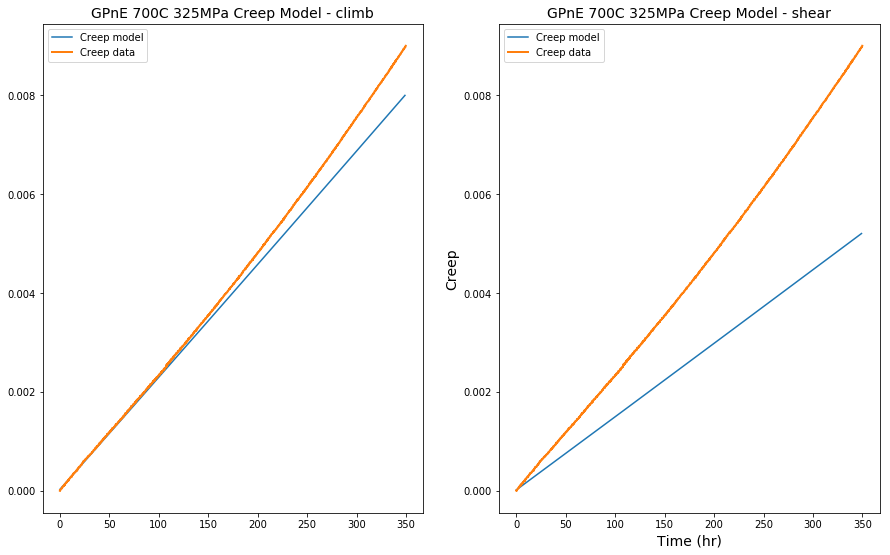

In [14]:
gpe700325.plotboth() # Weaker than model prediction

#### 700C 350MPa

In [15]:
gp700350 = Cdata(sheet1.iloc[15:, 6:8].dropna().reset_index(),1,700,350,50,300,A,C,10028)

GP only 700C 350MPa condition with climb mechanism - error: -0.6860808354227026
GP only 700C 350MPa condition with shear mechanism - error: -0.0021830924569063398


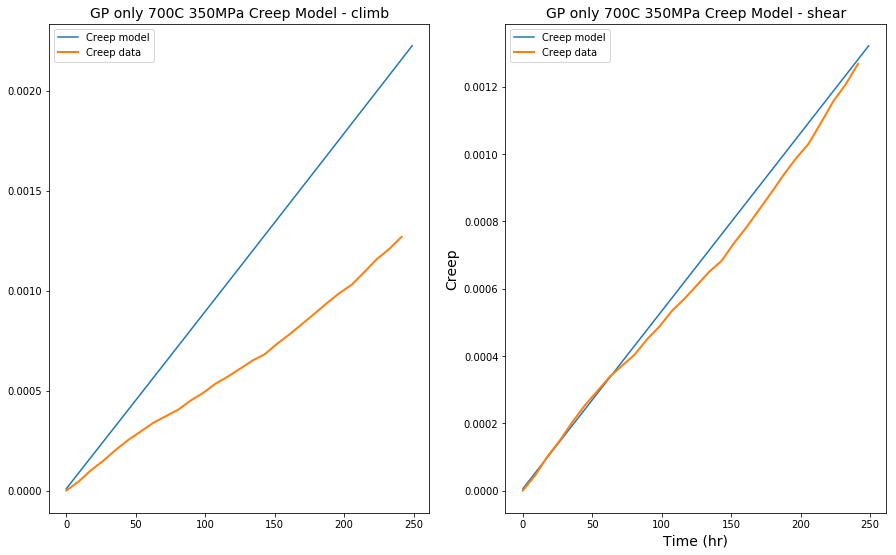

In [16]:
gp700350.plotboth()

#### 700C 400MPa

In [17]:
gp700400 = Cdata(sheet1.iloc[15:, 21:23].dropna().reset_index(),1,700,400,10,70,A,C,90000)
gpe700400 = Cdata(sheet5.iloc[27:, 18:20].dropna().reset_index(),2,700,400,20,140,A,C,90000)

GP only 700C 400MPa condition with climb mechanism - error: -0.4333985129478599
GP only 700C 400MPa condition with shear mechanism - error: 0.01765800966302269


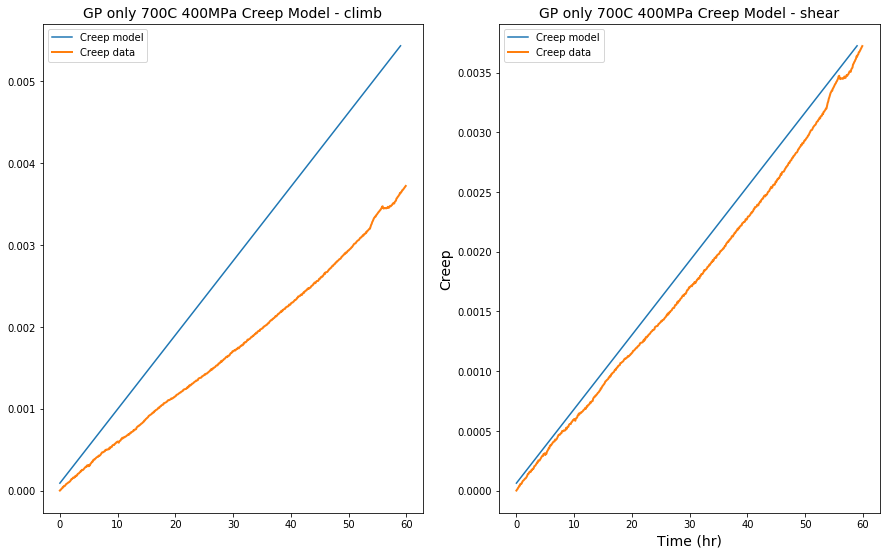

In [18]:
gp700400.plotboth()

GPnE 700C 400MPa condition with climb mechanism - error: 0.535425875048133
GPnE 700C 400MPa condition with shear mechanism - error: 0.6543773340511132


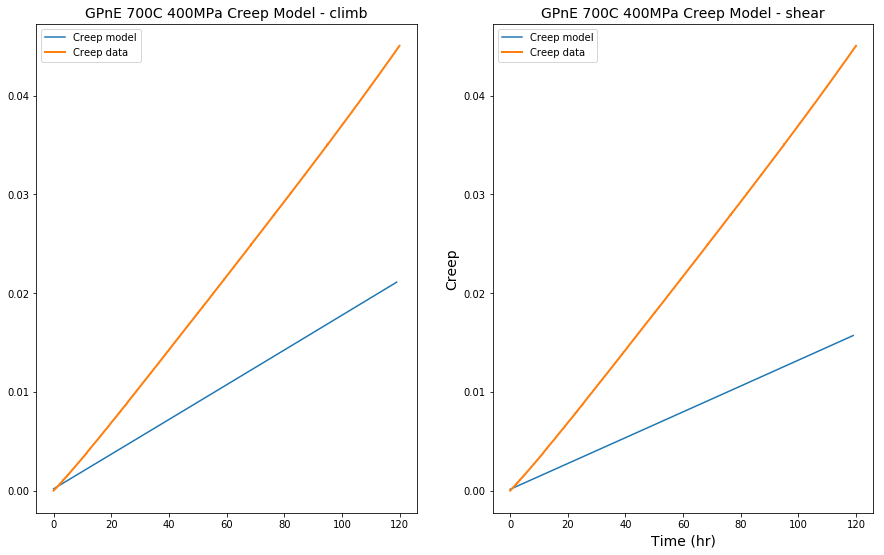

In [19]:
gpe700400.plotboth() # Weaker than model prediction

#### 750C 150MPa

In [20]:
gp750150 = Cdata(sheet1.iloc[15:, 18:20].dropna().reset_index(),1,750,150,500,2500,A,C,24211)

GP only 750C 150MPa condition with climb mechanism - error: -8.16585207753726
GP only 750C 150MPa - Zero effective stress detected at some point
GP only 750C 150MPa condition with shear mechanism - error: 1.0


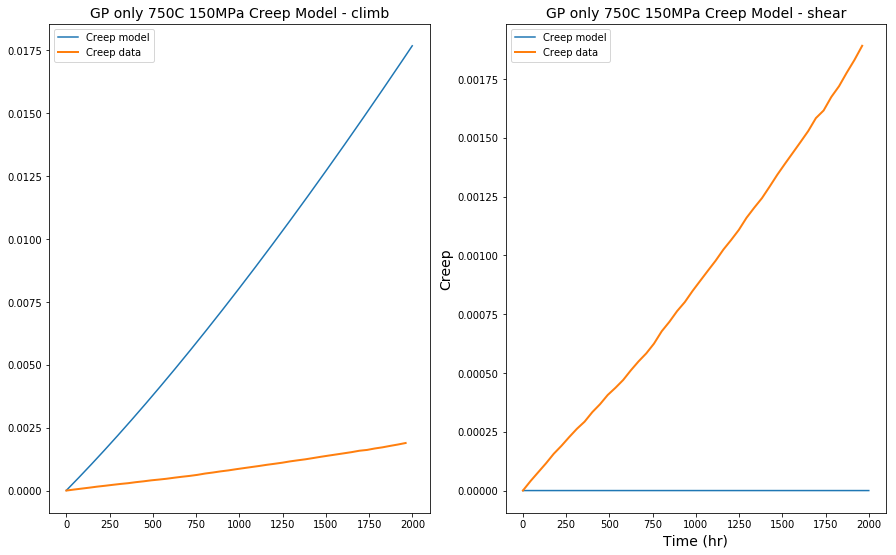

In [21]:
gp750150.plotboth()

#### 750C 180MPa

In [22]:
# IGNORE
gp750180 = Cdata(sheet1.iloc[15:, 0:2].dropna().reset_index(),1,750,180,500,1500,A,C,30000)

GP only 750C 180MPa condition with climb mechanism - error: -8.902374893421568
GP only 750C 180MPa - Zero effective stress detected at some point
GP only 750C 180MPa condition with shear mechanism - error: 0.8560254551091083


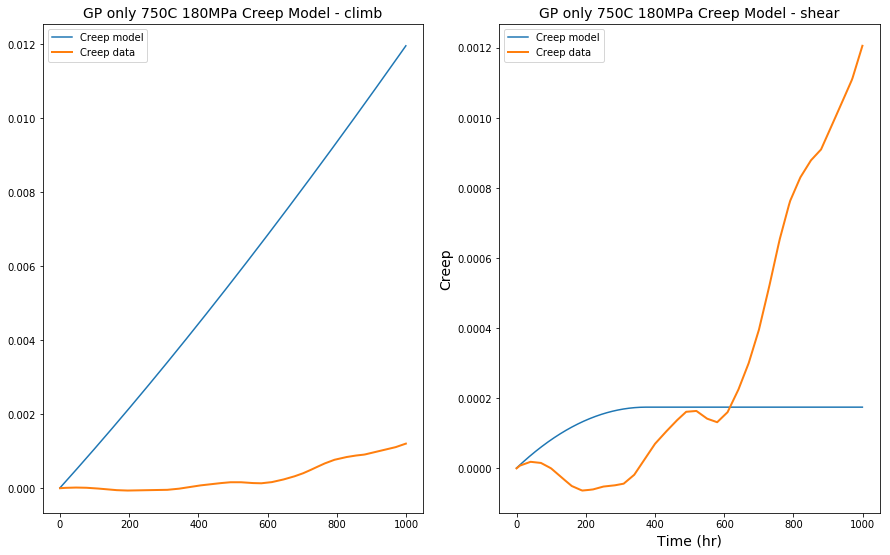

In [23]:
gp750180.plotboth()

#### 750C 200MPa

In [24]:
# gp750200 = Cdata(sheet1.iloc[15:, 15:17].dropna().reset_index(),1,750,200,550,1000,A,C,90000)
gp750200 = Cdata(sheet1.iloc[15:, 15:17].dropna().reset_index(),1,750,200,200,500,A,C,25000)

# gpe750200 = Cdata(sheet5.iloc[27:, 24:26].dropna().reset_index(),2,750,200,35,300,A,C,90000) #53548
gpe750200 = Cdata(sheet5.iloc[27:, 24:26].dropna().reset_index(),2,750,200,35,300,A,C,25000) #53548

GP only 750C 200MPa condition with climb mechanism - error: -2.9658099150906856
GP only 750C 200MPa condition with shear mechanism - error: 0.0020927857525342153


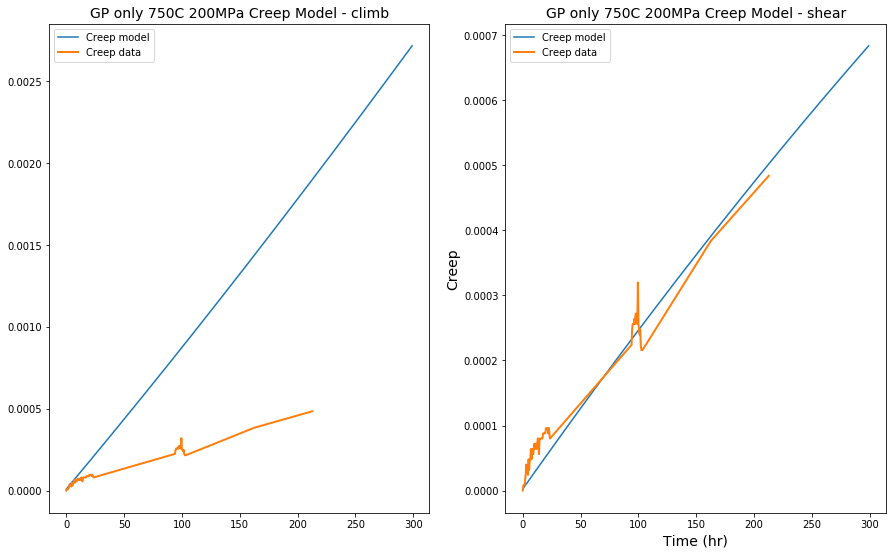

In [25]:
gp750200.plotboth()

GPnE 750C 200MPa condition with climb mechanism - error: -1.0027814416278895
GPnE 750C 200MPa condition with shear mechanism - error: 0.013021257218442382


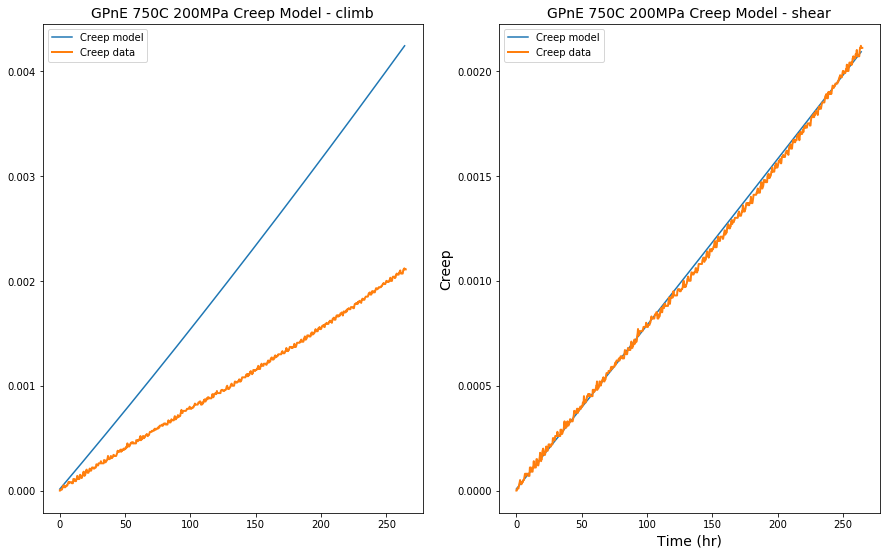

In [26]:
gpe750200.plotboth() # Stronger than model prediction

#### 750C 300MPa

In [27]:
gp750300 = Cdata(sheet5.iloc[27:, 0:2].dropna().reset_index(),1,750,300,10,40,A,C,66760)
gpe750300 = Cdata(sheet5.iloc[27:, 27:29].dropna().reset_index(),2,750,300,20,100,A,C,66760)

GP only 750C 300MPa condition with climb mechanism - error: -0.34717443899598155
GP only 750C 300MPa condition with shear mechanism - error: 0.08510454338235622


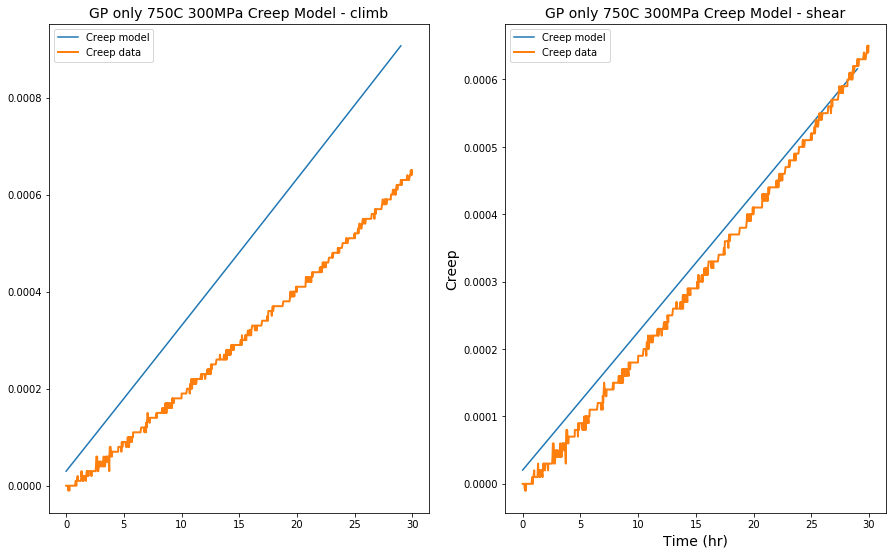

In [28]:
gp750300.plotboth()

GPnE 750C 300MPa condition with climb mechanism - error: 0.7695321620175971
GPnE 750C 300MPa condition with shear mechanism - error: 0.832814575710004


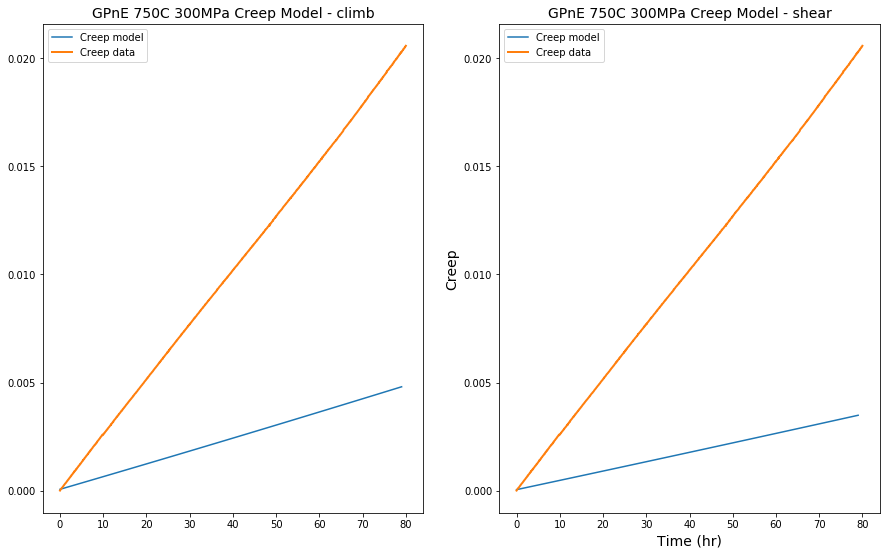

In [29]:
gpe750300.plotboth() # Weaker than model prediction

#### 800 100

In [33]:
gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(),1,800,100,150,1400,A,C,6000)
gpe800100 = Cdata(sheet5.iloc[27:, 30:32].dropna().reset_index(),2,800,100,100,1100,A,C,6000)

GP only 800C 100MPa condition with climb mechanism - error: 0.022854176821532908
GP only 800C 100MPa - Zero effective stress detected at some point
GP only 800C 100MPa condition with shear mechanism - error: 1.0


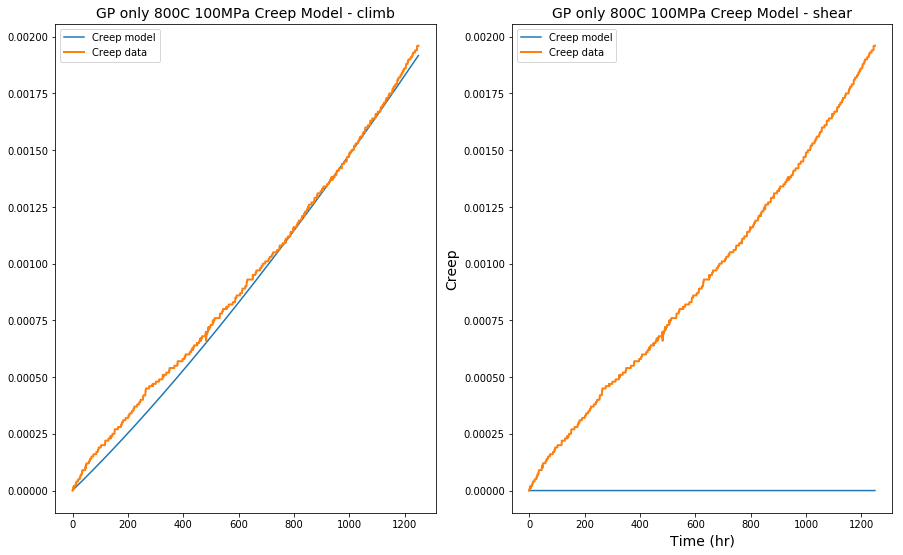

In [34]:
# gp800100.curve()
# # gp800100.plotss()
# gp800100.plotsst()
# # gp800100.plotpsize()
# # gp800100.plotcmodelonly()
# gp800100.plotcreep()
# gp800100.plotcreepss()
# gp800100.plotstress()

gp800100.plotboth()

GPnE 800C 100MPa condition with climb mechanism - error: 0.24506383143702498
GPnE 800C 100MPa - Zero effective stress detected at some point
GPnE 800C 100MPa condition with shear mechanism - error: 1.0


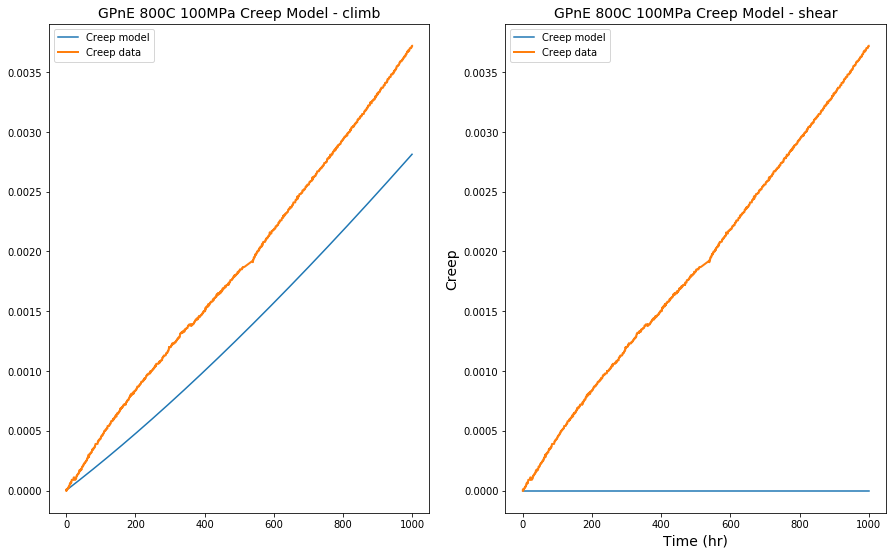

In [35]:
gpe800100.plotboth()

#### 800 125

In [36]:
gp800125 = Cdata(sheet5.iloc[27:, 6:8].dropna().reset_index(),1,800,125,150,800,A,C,6100)
gpe800125 = Cdata(sheet5.iloc[27:, 33:35].dropna().reset_index(),2,800,125,100,400,A,C,6100)

GP only 800C 125MPa condition with climb mechanism - error: 0.050907315820052736
GP only 800C 125MPa - Zero effective stress detected at some point
GP only 800C 125MPa condition with shear mechanism - error: 1.0


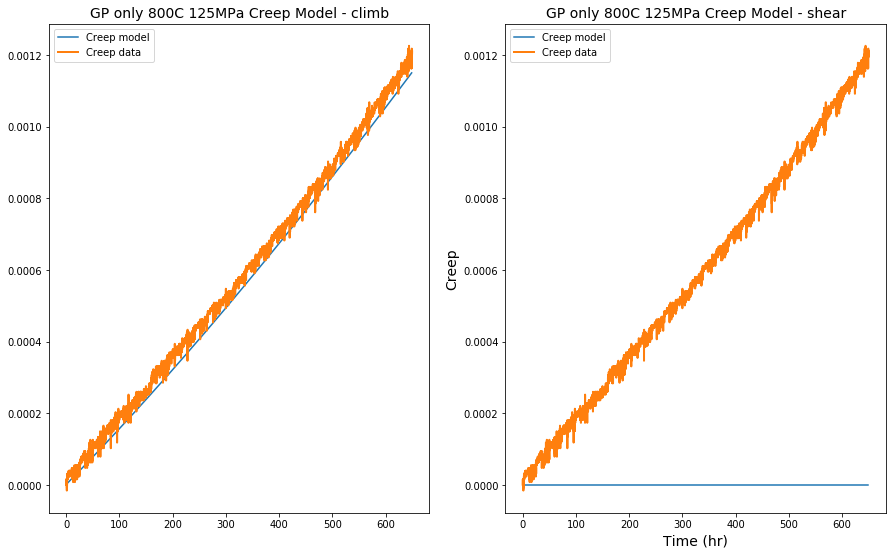

In [37]:
gp800125.plotboth()

GPnE 800C 125MPa condition with climb mechanism - error: 0.8011703224746995
GPnE 800C 125MPa - Zero effective stress detected at some point
GPnE 800C 125MPa condition with shear mechanism - error: 1.0


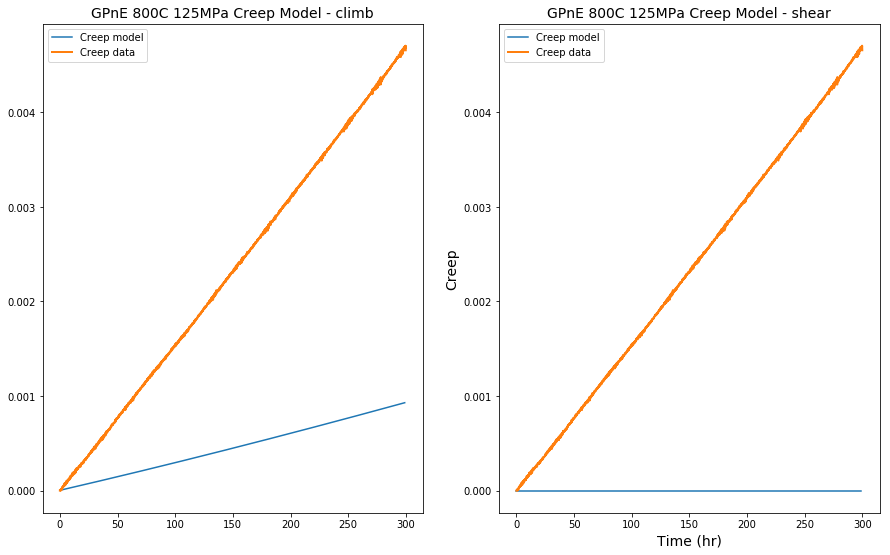

In [38]:
gpe800125.plotboth() # Weaker than model prediction

#### 800 145

In [39]:
gp800145 = Cdata(sheet5.iloc[27:, 9:11].dropna().reset_index(),1,800,145,2,4,A,C,6200) # Negative creep
gpe800145 = Cdata(sheet5.iloc[27:, 36:38].dropna().reset_index(),2,800,145,30,200,A,C,6200) # Change this

GP only 800C 145MPa condition with climb mechanism - error: 1.009752454660396
GP only 800C 145MPa - Zero effective stress detected at some point
GP only 800C 145MPa condition with shear mechanism - error: 1.0


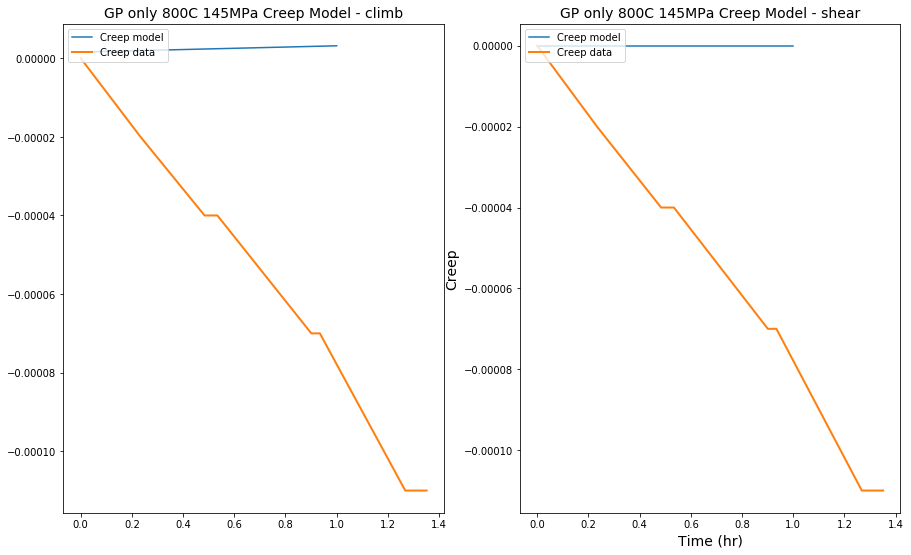

In [40]:
gp800145.plotboth() ## Negative creep, ignore

GPnE 800C 145MPa condition with climb mechanism - error: 0.9616720008957587
GPnE 800C 145MPa condition with shear mechanism - error: 0.9954663727305493


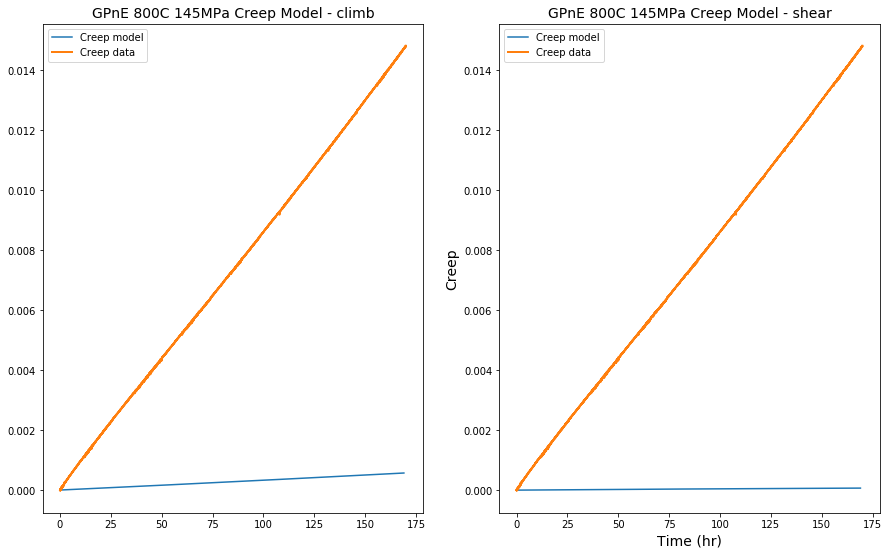

In [41]:
gpe800145.plotboth()

#### 800 250

In [58]:
gp800250 = Cdata(sheet5.iloc[27:, 42:44].dropna().reset_index(),1,800,250,4,15,A,C,450000)
gpe800250 = Cdata(sheet5.iloc[27:, 45:47].dropna().reset_index(),2,800,250,4,42,A,C,3500000) # Order of magnitude

In [47]:
# gp800250.plotboth()

GPnE 800C 250MPa condition with climb mechanism - error: 0.09036049195635106
GPnE 800C 250MPa condition with shear mechanism - error: 0.48000510558275544


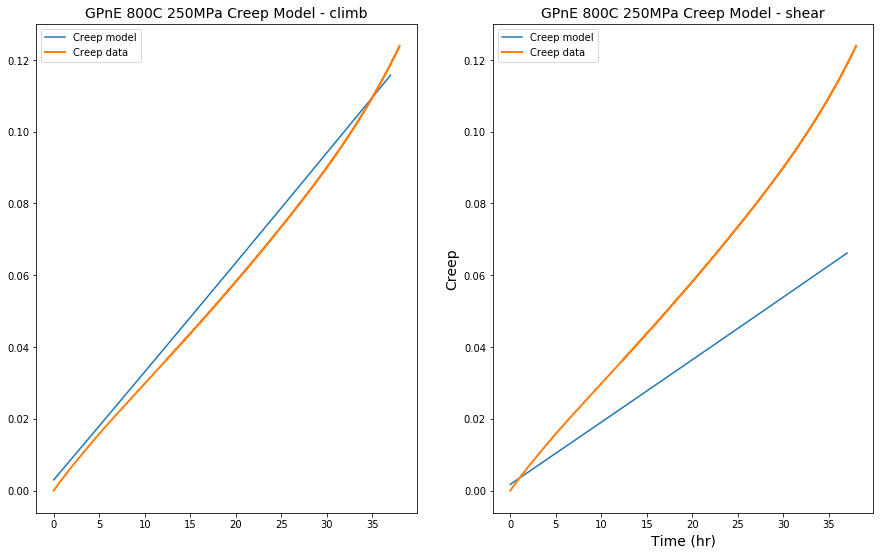

In [59]:
gpe800250.plotboth() # Weaker than model prediction

### Slope combinations - gp, gpne, e

In [13]:
%matplotlib inline

In [12]:
plotting = True

700C 325MPa mix proportions: 0.508264298430872gp 0.49173570156912805e


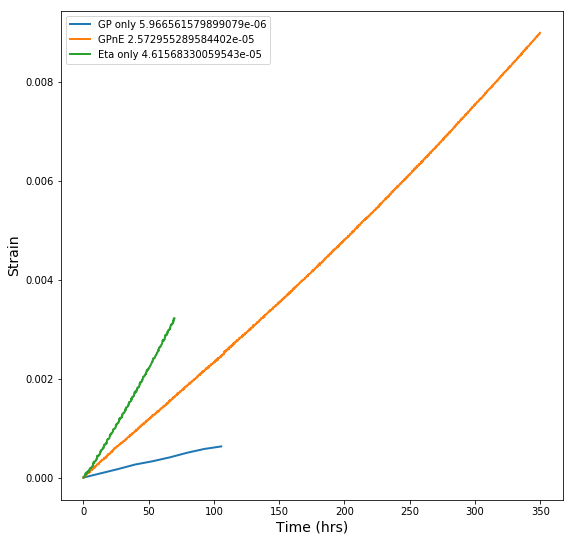

In [38]:
# # 700C 325MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp700320.subplots(plotting)
gpe = gpe700325.subplots(plotting)
e = e700325_1.subplots(plotting)
# e = e700325_2.subplots(plotting)

x700325 = (gpe-e)/(gp-e)
print(f'700C 325MPa mix proportions: {x700325}gp {1-x700325}e')

plt.legend(loc="upper left")



700C 400MPa mix proportions: -2.7461641579383325gp 3.7461641579383325e


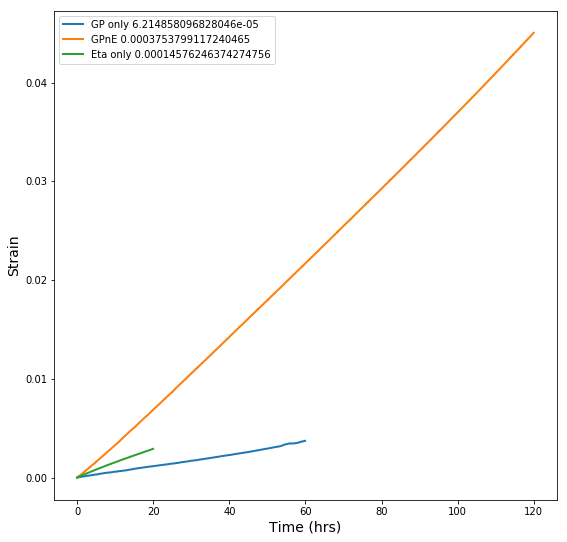

In [37]:
# # 700C 400MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp700400.subplots(plotting)
gpe = gpe700400.subplots(plotting)
# e = e700400_1.subplots(plotting)
e = e700400_2.subplots(plotting)

x700400 = (gpe-e)/(gp-e)
print(f'700C 400MPa mix proportions: {x700400}gp {1-x700400}e')

plt.legend(loc="upper left")

750C 200MPa mix proportions: 0.9673153457857465gp 0.032684654214253483e


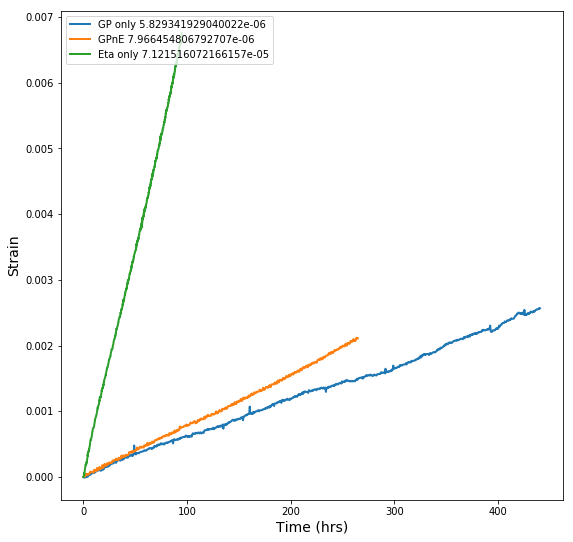

In [29]:
# # 750C 200MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp750200.subplots(plotting)
gpe = gpe750200.subplots(plotting)
e = e750220.subplots(plotting)

x750200 = (gpe-e)/(gp-e)
print(f'750C 200MPa mix proportions: {x750200}gp {1-x750200}e')

plt.legend(loc="upper left")

750C 300MPa mix proportions: 0.18188919804802312gp 0.8181108019519769e


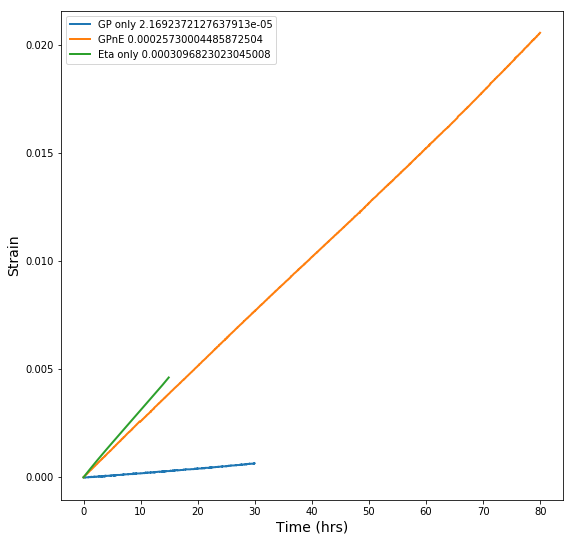

In [30]:
# # 750C 300MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp750300.subplots(plotting)
gpe = gpe750300.subplots(plotting)
e = e750300_1.subplots(plotting)
# e = e750300_2.subplots(plotting)

x750300 = (gpe-e)/(gp-e)
print(f'750C 300MPa mix proportions: {x750300}gp {1-x750300}e')

plt.legend(loc="upper left")

800C 100MPa mix proportions: 0.9001098537143897gp 0.09989014628561033e


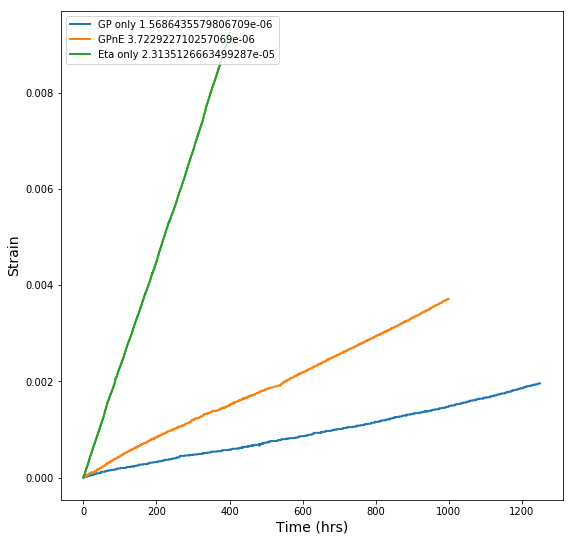

In [31]:
# # 800C 100MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp800100.subplots(plotting)
gpe = gpe800100.subplots(plotting)
e = e800100_1.subplots(plotting)
# e = e800100_2.subplots(plotting)

x800100 = (gpe-e)/(gp-e)
print(f'800C 100MPa mix proportions: {x800100}gp {1-x800100}e')

plt.legend(loc="upper left")

800C 125MPa mix proportions: 0.8225520736801637gp 0.1774479263198363e


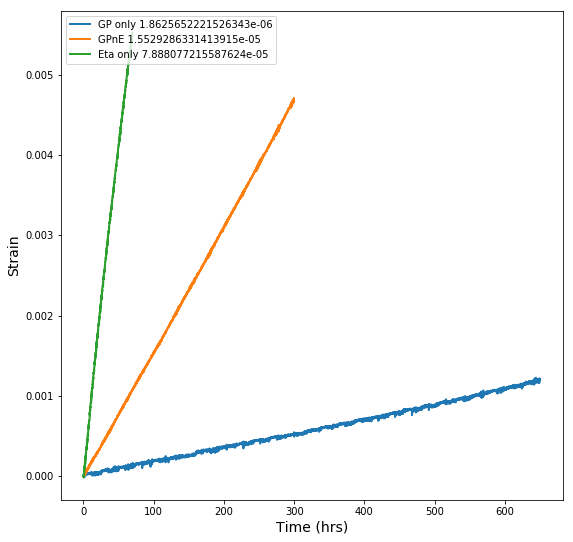

In [32]:
# # 800C 125MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp800125.subplots(plotting)
gpe = gpe800125.subplots(plotting)
e = e800145_3.subplots(plotting)

x800125 = (gpe-e)/(gp-e)
print(f'800C 125MPa mix proportions: {x800125}gp {1-x800125}e')

plt.legend(loc="upper left")

800C 145MPa mix proportions: 0.14411041149538403gp 0.8558895885046159e


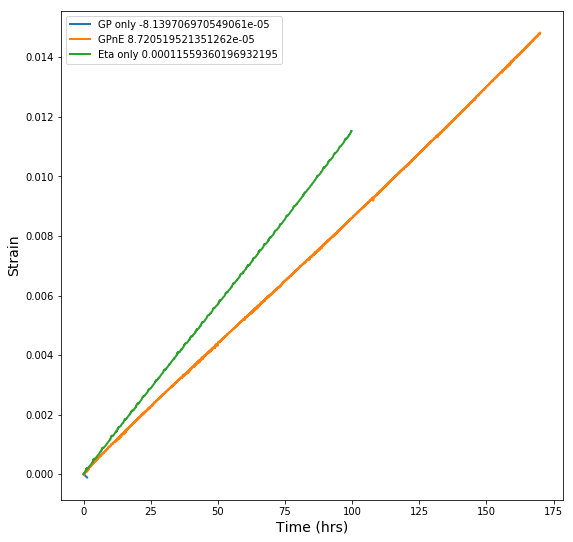

In [33]:
# # 800C 145MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp800145.subplots(plotting)
gpe = gpe800145.subplots(plotting)
e = e800145_1.subplots(plotting)
# e = e800145_2.subplots(plotting)

x800145 = (gpe-e)/(gp-e)
print(f'800C 145MPa mix proportions: {x800145}gp {1-x800145}e')

plt.legend(loc="upper left")

800C 250MPa mix proportions: -0.6552477355667299gp 1.6552477355667299e


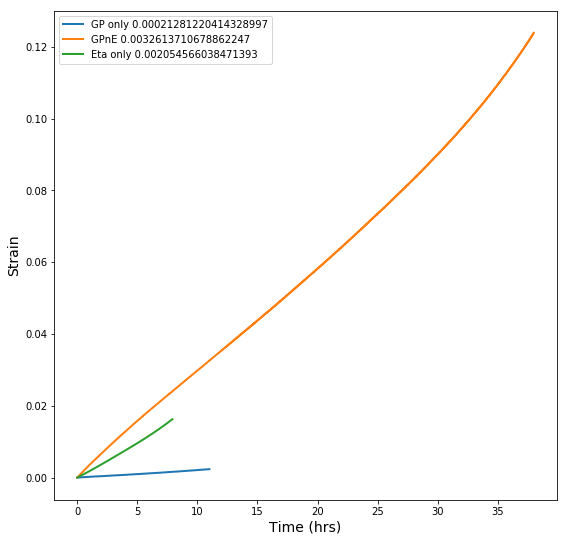

In [34]:
# # 800C 250MPa
# plotting = False
if plotting:
    plt.figure(figsize=(9, 9))
    plt.xlabel('Time (hrs)', fontsize=14)
    plt.ylabel('Strain', fontsize=14)

gp = gp800250.subplots(plotting)
gpe = gpe800250.subplots(plotting)
e = e800250_1.subplots(plotting)
# e = e800250_2.subplots(plotting)

x800250 = (gpe-e)/(gp-e)
print(f'800C 250MPa mix proportions: {x800250}gp {1-x800250}e')

plt.legend(loc="upper left")

In [36]:
print(f'700C 325MPa mix proportions: {x700325:.3f}gp \t {1-x700325:.3f}e')
print(f'700C 400MPa mix proportions: {x700400:.3f}gp \t {1-x700400:.3f}e') # Cuvres inverse
print()
print(f'750C 200MPa mix proportions: {x750200:.3f}gp \t {1-x750200:.3f}e')
print(f'750C 300MPa mix proportions: {x750300:.3f}gp \t {1-x750300:.3f}e')
print()
print(f'800C 100MPa mix proportions: {x800100:.3f}gp \t {1-x800100:.3f}e')
print(f'800C 125MPa mix proportions: {x800125:.3f}gp \t {1-x800125:.3f}e')
print(f'800C 145MPa mix proportions: {x800145:.3f}gp \t {1-x800145:.3f}e') # Negative creep
print(f'800C 250MPa mix proportions: {x800250:.3f}gp \t {1-x800250:.3f}e') # Cuvres inverse


700C 325MPa mix proportions: 0.508gp 	 0.492e


NameError: name 'x700400' is not defined

Low stresses / higher temperatures - mixed microstructure is closer to gp only

Where we expect shear - closer to eta?

### Error dict

In [57]:
errordict={}

# SORTED BY SOURCE

# # gp700280.export_params(errordict,'Shear')
# gp700320.export_params(errordict,'Shear')
# # gp700350.export_params(errordict,'Shear')
# gp700400.export_params(errordict,'Shear')

# # gp750150.export_params(errordict,'Shear + SF')
# # gp750180.export_params(errordict,'Shear + SF')
# # gp750198.export_params(errordict,'Shear + SF')
# gp750200.export_params(errordict,'Shear + SF')

# gp750300.export_params(errordict,'Shear + SF')
# gp800100.export_params(errordict,'Climb')
# gp800125.export_params(errordict,'Climb')
# # gp800145.export_params(errordict,'Climb')
# gp800250.export_params(errordict,'Climb')

# gpe700325.export_params(errordict,'SF')
# gpe700400.export_params(errordict,'SF')
# gpe750200.export_params(errordict,'SF')
# gpe750300.export_params(errordict,'SF')
# gpe800100.export_params(errordict,'Climb + SF')
# gpe800125.export_params(errordict,'Climb + SF')
# # gpe800145.export_params(errordict,'Climb + SF')
# gpe800250.export_params(errordict,'Climb + SF')

# SORTED BY MATERIALS

gp700280.export_params(errordict,'Shear')
gp700320.export_params(errordict,'Shear')
gp700350.export_params(errordict,'Shear')
gp700400.export_params(errordict,'Shear')
gpe700325.export_params(errordict,'SF')
gpe700400.export_params(errordict,'SF')

# gp750150.export_params(errordict,'Shear + SF')
# gp750180.export_params(errordict,'Shear + SF')
# gp750198.export_params(errordict,'Shear + SF')
gp750200.export_params(errordict,'Shear + SF')
gp750300.export_params(errordict,'Shear + SF')
gpe750200.export_params(errordict,'SF')
gpe750300.export_params(errordict,'SF')

gp800100.export_params(errordict,'Climb')
gp800125.export_params(errordict,'Climb')
# gp800145.export_params(errordict,'Climb')
gp800250.export_params(errordict,'Climb')
gpe800100.export_params(errordict,'Climb + SF')
gpe800125.export_params(errordict,'Climb + SF')
# gpe800145.export_params(errordict,'Climb + SF')
gpe800250.export_params(errordict,'Climb + SF')

# SORTED BY STRESS

# # gp700280.export_params(errordict,'Shear')
# gp700320.export_params(errordict,'Shear')
# # gpe700325.export_params(errordict,'SF')
# gp700350.export_params(errordict,'Shear')
# gp700400.export_params(errordict,'Shear')
# gpe700400.export_params(errordict,'SF')

# # gp750150.export_params(errordict,'Shear + SF')
# # gp750180.export_params(errordict,'Shear + SF')
# # gp750198.export_params(errordict,'Shear + SF')
# gp750200.export_params(errordict,'Shear + SF')
# gpe750200.export_params(errordict,'SF')
# gp750300.export_params(errordict,'Shear + SF')
# gpe750300.export_params(errordict,'SF')

# gp800100.export_params(errordict,'Climb')
# gpe800100.export_params(errordict,'Climb + SF')
# gp800125.export_params(errordict,'Climb')
# gpe800125.export_params(errordict,'Climb + SF')
# # gp800145.export_params(errordict,'Climb')
# # gpe800145.export_params(errordict,'Climb + SF')
# gp800250.export_params(errordict,'Climb')
# gpe800250.export_params(errordict,'Climb + SF')



errordf = pd.DataFrame.from_dict(errordict,orient='index',columns=['Expected Mech','Dislocation Density', 'Climb Error','Shear Error','Model slope','Data slope','Steady state start','Steady state end'])

GP only 800C 100MPa - Zero effective stress detected at some point
GP only 800C 125MPa - Zero effective stress detected at some point
GPnE 800C 100MPa - Zero effective stress detected at some point
GPnE 800C 125MPa - Zero effective stress detected at some point


In [58]:
errordf
# Positive error indicates Model stronger than Data

,Expected Mech,Dislocation Density,Climb Error,Shear Error,Model slope,Data slope,Steady state start,Steady state end
GP only 700C 280MPa,Shear,5773,-1.869920,-0.143703,0.000002,0.000002,350,750
GP only 700C 320MPa,Shear,14282,-1.074473,-0.073585,0.000006,0.000006,50,160
GP only 700C 350MPa,Shear,10028,-0.837207,-0.064230,0.000006,0.000005,50,300
GP only 700C 400MPa,Shear,95125,-0.669686,-0.113694,0.000069,0.000062,10,70
GPnE 700C 325MPa,SF,14282,-0.073574,0.357753,0.000028,0.000026,50,400
GPnE 700C 400MPa,SF,95125,0.362021,0.568042,0.000239,0.000375,20,140
GP only 750C 200MPa,Shear + SF,82000,-5.222294,0.076596,0.000036,0.000006,550,1000
GP only 750C 300MPa,Shear + SF,66760,-0.425274,0.037507,0.000031,0.000022,10,40
GPnE 750C 200MPa,SF,82000,-6.046171,-2.409145,0.000056,0.000008,35,300
GPnE 750C 300MPa,SF,66760,0.747017,0.820533,0.000065,0.000257,20,100


Notes:

700C - Curves make sense. Same trends seen for each set of tests (no change of sign). Models predict lower creep rate for mixed microstructure, because eta, gp denuded zones not accounted for.

750C - For both microstructures, we expect shear + SF here. Things dont work out well. Shear curve fits data well for gp only tests, BUT dislocation densities are an issue. Trend reversal seen in mixed microstructures. The 'problem' is gp+e 700C 200MPa. Not surprising, since we need an SF model
UPDATE: Steady state region for gp only 750C 200MPa changed. All good now.

800C - All curves make sense. Models predict lower creep rate for mixed microstructure.

In [96]:
# errordf.to_excel("Error data frame.xlsx",sheet_name='Sheet_name_1')  

### Sensitivity Analysis

Choosing gp only 800C 100MPa for sensitivity analysis

In [85]:
# Original A,C values
A = 5.966816326530612e-10 # /s
C = 0.00010228

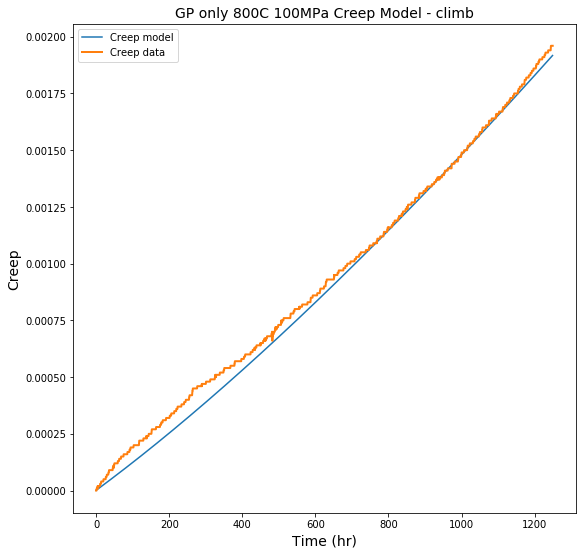

In [76]:
gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(),1,800,100,150,1400,A,C,6000)
gp800100.plotcreepss()

#### Changing A - 50% to 150%

In [82]:
A_change = [x*A/100 for x in range(50,160,10)]
A_change

[2.983408163265306e-10,
 3.580089795918367e-10,
 4.1767714285714287e-10,
 4.773453061224489e-10,
 5.370134693877552e-10,
 5.966816326530612e-10,
 6.563497959183674e-10,
 7.160179591836734e-10,
 7.756861224489796e-10,
 8.353542857142857e-10,
 8.950224489795919e-10]

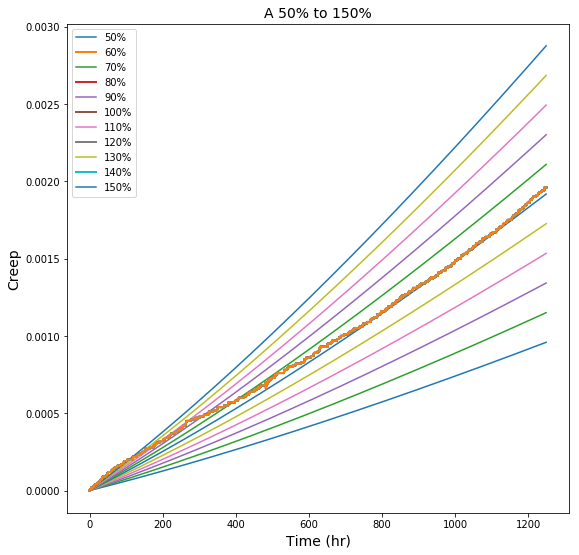

In [83]:
plt.figure(figsize=(9, 9))
plt.title('A 50% to 150%', fontsize=14)
plt.xlabel('Time (hr)', fontsize=14)
plt.ylabel('Creep', fontsize=14)


for A_c in A_change:
    gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(), 1, 800, 100, 150, 1400, A_c, C, 6000)
    gp800100.subplots()

plt.legend(('50%','60%','70%','80%','90%','100%','110%','120%','130%','140%','150%'))
# plt.legend(loc="upper left")
plt.show()


The legend is not displaying colors properly, but the lowest curve is 50% A, highest curve is 150% A

#### Changing C

In [84]:
C_change = [x*C/100 for x in range(50,160,10)]
C_change

[5.114e-05,
 6.1368e-05,
 7.1596e-05,
 8.1824e-05,
 9.2052e-05,
 0.00010228,
 0.000112508,
 0.000122736,
 0.000132964,
 0.000143192,
 0.00015342]

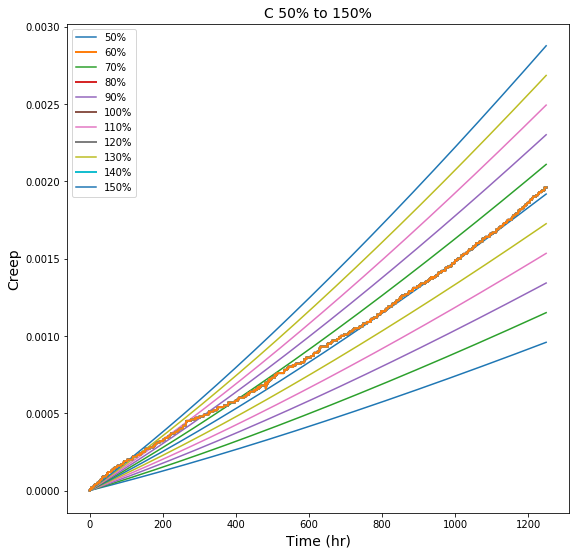

In [110]:
plt.figure(figsize=(9, 9))
plt.title('C 50% to 150%', fontsize=14)
plt.xlabel('Time (hr)', fontsize=14)
plt.ylabel('Creep', fontsize=14)


for C_c in C_change:
#     print(C_c)
    gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(), 1, 800, 100, 150, 1400, A, C_c, 6000)
    gp800100.subplots()

plt.legend(('50%','60%','70%','80%','90%','100%','110%','120%','130%','140%','150%'))
# plt.legend(loc="upper left")
plt.show()

The legend is not displaying colors properly, but the lowest curve is 50% C, highest curve is 150% C

#### Finally, chaning the dislocation density rho

In [87]:
rho_change = [x*6000/100 for x in range(50,160,10)]
rho_change

[3000.0,
 3600.0,
 4200.0,
 4800.0,
 5400.0,
 6000.0,
 6600.0,
 7200.0,
 7800.0,
 8400.0,
 9000.0]

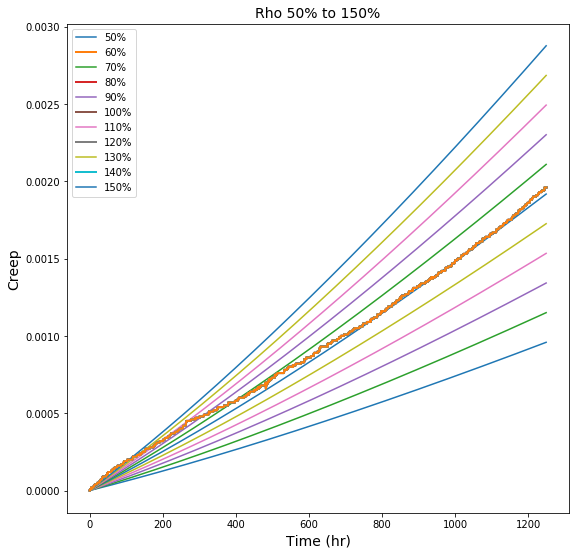

In [91]:
plt.figure(figsize=(9, 9))
plt.title('Rho 50% to 150%', fontsize=14)
plt.xlabel('Time (hr)', fontsize=14)
plt.ylabel('Creep', fontsize=14)


for rho_c in rho_change:
    gp800100 = Cdata(sheet5.iloc[27:, 3:5].dropna().reset_index(), 1, 800, 100, 150, 1400, A, C, rho_c)
    gp800100.subplots()

plt.legend(('50%','60%','70%','80%','90%','100%','110%','120%','130%','140%','150%'))
# plt.legend(loc="upper left")
plt.show()